In [1]:
import numpy as np 
import pandas as pd
import os 
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.feature_selection import SelectFromModel

from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

# Existing Building Damage State Model

In [2]:
os.chdir(r'C:\Users\User\Desktop\XGBoostPipline')

DamageState_Existing = pd.read_csv(r'DamageStateMedian_Existing.csv', index_col='Index')
DamageState_Verification = pd.read_csv(r'DamageStateMedian_Verification.csv', index_col='Index')
DamageState_Verification = DamageState_Verification.iloc[0:32,:]

DesignMatrix_Existing = pd.read_csv(r'ExistingTrainTestDesignMatrix.csv', index_col='Index')
DesignMatrix_Verification = pd.read_csv(r'ExistingVerificationDesignMatrix.csv', index_col='Index')
DesignMatrix_Verification = DesignMatrix_Verification.iloc[0:32,:]

In [3]:
def param_randomizedtune_pipline(model, X_train, X_test, y_train, y_test, param_grid, plot_flag = True):

    rs_clf = RandomizedSearchCV(model, 
    param_grid, 
    n_iter=10, 
    n_jobs = 8,
    cv = 10,
    scoring='median_absolute_error',
    refit = True, 
    random_state = 10086, verbose = 0)

    rs_clf.fit(X_train, y_train)

    score = rs_clf.best_score_
    param_recommend = rs_clf.best_params_

    train_pred = rs_clf.predict(X_train)
    train_pred = train_pred.reshape(y_train.shape)
    test_pred = rs_clf.predict(X_test)
    test_pred = test_pred.reshape(y_test.shape)

    print('Training Median Absolute Error Ratio %.2f'%(100*np.divide(np.abs(train_pred - y_train),y_train).mean()))
    print('Testing Median Absolute Error Ratio %.2f'%(100*np.divide(np.abs(test_pred - y_test),y_test).mean()))


    if plot_flag:
        plt.scatter(y_train, train_pred, color = 'blue', label = 'Train')
        plt.scatter(y_test, test_pred, color = 'red', label = 'Test')
        plt.plot([y_train.min(), y_train.max()],[y_train.min(), y_train.max()], color = 'black', linewidth = 2)
        plt.xlabel('Actual Median DS Inensity (g)')
        plt.ylabel('Predicted Median DS Intensity (g)')
        plt.legend()

    return rs_clf

def param_bayesiantune_pipline(model, param_range, X_train, X_test, y_train, y_test, init_points, n_iter):
    def cross_val_loss():
        return cross_val_score(model, X_train, y_train, cv = 10).median() 

    optimizer = BayesianOptimization(f = cross_val_loss,
                                    pbounds = param_range,
                                    random_state = 10086)
    optimizer.maximize(init_points, n_iter)

    param_recommend = optimizer.max()

    model_best = model(param_recommend)
    model_best.fit(X_train, y_train)

    train_pred = model_best.fit(X_train)
    test_pred = model_best.predict(X_test)

    print('Training Median Absolute Error Ratio %.2f'%(100*np.divide(np.abs(train_pred - y_train),y_train).mean()))
    print('Testing Median Absolute Error Ratio %.2f'%(100*np.divide(np.abs(test_pred - y_test),y_test).mean()))


    if plot_flag:
        plt.scatter(y_train, train_pred, color = 'blue', label = 'Train')
        plt.scatter(y_test, test_pred, color = 'red', label = 'Test')
        plt.plot([y_train.min(), y_train.max()],[y_train.min(), y_train.max()], color = 'black', linewidth = 2)
        plt.xlabel('Actual Median DS Inensity (g)')
        plt.ylabel('Predicted Median DS Intensity (g)')
        plt.legend()

    return model_best
    

In [4]:
param_grid = {'num_feature':[5,10,15,20],
'eta':[0.01,0.015,0.02,0.025,0.05,0.1,0.5,1.0],
'gamma':[0, 0.001,0.01,0.015,0.02,0.025,0.03,0.05,0.1,0.5],
'max_depth':[100,200,300,400,500,600,700,800,1000,2000],
'subsample':[0.1,0.2,0.3,0.4,0.5,0.8,1],
'lambda':[0,0.1,0.2,0.3,0.4,0.5,0.8,1.0],
'alpha':[0,0.1,0.2,0.3,0.4,0.5,0.8,1.0]}

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[20:33:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 2.72
Testing Median Absolute Error Ratio 4.89


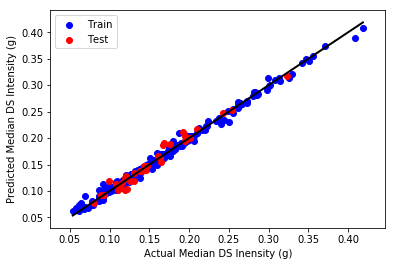

In [5]:
# XGB_NoDamage = param_randomizedtune_pipline(XGBRegressor(), DesignMatrix_Existing, DesignMatrix_Verification, DamageState_Existing['NoDamage'], DamageState_Verification['NoDamage'], param_grid, plot_flag = True)

X_train, X_test, y_train, y_test = train_test_split(DesignMatrix_Existing.append(DesignMatrix_Verification), DamageState_Existing['NoDamage'].append(DamageState_Verification['NoDamage']),test_size = 0.1)

XGB_NoDamage = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train, y_test, param_grid, plot_flag = True)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[20:33:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 1.50
Testing Median Absolute Error Ratio 3.94


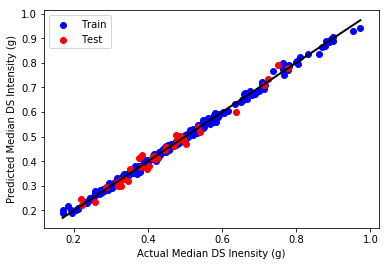

In [6]:
# XGB_Slight = param_randomizedtune_pipline(XGBRegressor(), DesignMatrix_Existing, DesignMatrix_Verification, DamageState_Existing['Slight'], DamageState_Verification['Slight'], param_grid, plot_flag = True)

X_train, X_test, y_train, y_test = train_test_split(DesignMatrix_Existing.append(DesignMatrix_Verification), DamageState_Existing['Slight'].append(DamageState_Verification['Slight']),test_size = 0.1)

XGB_Slight = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train, y_test, param_grid, plot_flag = True)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[20:33:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 1.67
Testing Median Absolute Error Ratio 4.97


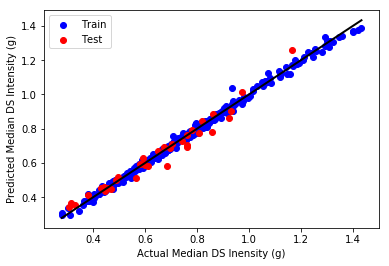

In [7]:
# XGB_Moderate = param_randomizedtune_pipline(XGBRegressor(), DesignMatrix_Existing, DesignMatrix_Verification, DamageState_Existing['Moderate'], DamageState_Verification['Moderate'], param_grid, plot_flag = True)

X_train, X_test, y_train, y_test = train_test_split(DesignMatrix_Existing.append(DesignMatrix_Verification), DamageState_Existing['Moderate'].append(DamageState_Verification['Moderate']),test_size = 0.1)

XGB_Moderate = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train, y_test, param_grid, plot_flag = True)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[20:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 2.12
Testing Median Absolute Error Ratio 5.52


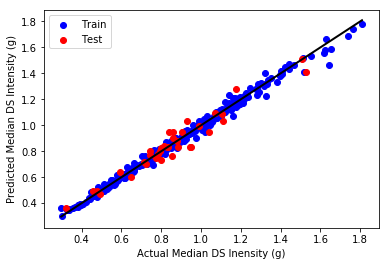

In [8]:
# XGB_Severe = param_randomizedtune_pipline(XGBRegressor(), DesignMatrix_Existing, DesignMatrix_Verification, DamageState_Existing['Severe'], DamageState_Verification['Severe'], param_grid, plot_flag = True)

X_train, X_test, y_train, y_test = train_test_split(DesignMatrix_Existing.append(DesignMatrix_Verification), DamageState_Existing['Severe'].append(DamageState_Verification['Severe']),test_size = 0.1)

XGB_Severe = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train, y_test, param_grid, plot_flag = True)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[20:33:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 2.35
Testing Median Absolute Error Ratio 5.65


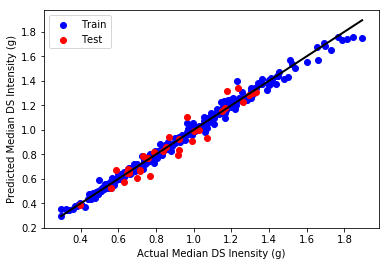

In [9]:
# XGB_Complete = param_randomizedtune_pipline(XGBRegressor(), DesignMatrix_Existing, DesignMatrix_Verification, DamageState_Existing['Complete'], DamageState_Verification['Complete'], param_grid, plot_flag = True)

X_train, X_test, y_train, y_test = train_test_split(DesignMatrix_Existing.append(DesignMatrix_Verification), DamageState_Existing['Complete'].append(DamageState_Verification['Complete']),test_size = 0.1)

XGB_Complete = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train, y_test, param_grid, plot_flag = True)

# Retrofitted Building Model

In [10]:
os.chdir(r'C:\Users\User\Desktop\XGBoostPipline')

DamageState_Existing = pd.read_csv(r'DamageStateMedian_Existing.csv')
DamageState_Verification = pd.read_csv(r'DamageStateMedian_Verification.csv')
DamageState_Retrofit = pd.read_csv(r'DamageStateMedian_Retrofit.csv')

DesignMatrix_Existing = pd.read_csv(r'ExistingTrainTestDesignMatrix.csv')
DesignMatrix_Verification = pd.read_csv(r'ExistingVerificationDesignMatrix.csv')
RetrofittedResults = pd.read_csv(r'RetrofittedDesignMatrix.csv')
#############################
Retrofit_TrainTest_DesignMatrix = RetrofittedResults.drop(columns = ['Index'])
Retrofit_TrainTest_DesignMatrix['Xpeakstrength'] = np.divide(RetrofittedResults['Xpeakstrength'],np.repeat(DesignMatrix_Existing['Xpeakstrength'],5)) 
Retrofit_TrainTest_DesignMatrix['Zpeakstrength'] = np.divide(RetrofittedResults['Zpeakstrength'],np.repeat(DesignMatrix_Existing['Zpeakstrength'],5)) 
#############################
Retrofit_Verification_DesignMatrix = DesignMatrix_Verification.iloc[32:,:].drop(columns = ['Index'])
Retrofit_Verification_DesignMatrix = Retrofit_Verification_DesignMatrix.drop(columns = ['Xdrift@peakstrength','Xdrift@80%peakstrength','Xdrift@20%residualstrength','Zdrift@peakstrength','Zdrift@80%peakstrength','Zdrift@20%residualstrength'])

Retrofit_Verification_DesignMatrix['Xpeakstrength'] = np.divide(Retrofit_Verification_DesignMatrix['Xpeakstrength'],pd.concat([DesignMatrix_Verification.loc[0:31,'Xpeakstrength']]*4)) 
Retrofit_Verification_DesignMatrix['Zpeakstrength'] = np.divide(Retrofit_Verification_DesignMatrix['Zpeakstrength'],pd.concat([DesignMatrix_Verification.loc[0:31,'Zpeakstrength']]*4)) 
#############################

[20:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 2.77
Testing Median Absolute Error Ratio 9.31


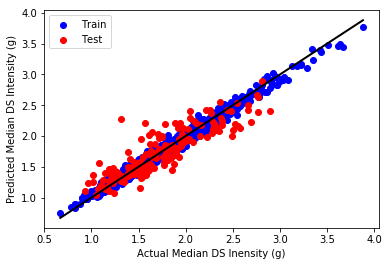

In [11]:
# reXGB_NoDamage = param_randomizedtune_pipline(XGBRegressor(), Retrofit_TrainTest_DesignMatrix, Retrofit_Verification_DesignMatrix, np.divide(DamageState_Retrofit['NoDamage'], np.repeat(DamageState_Existing['NoDamage'],5)), 
# np.divide(DamageState_Verification.loc[32:,'NoDamage'], pd.concat([DamageState_Verification.loc[0:31,'NoDamage']]*4)), param_grid, plot_flag = True)

DF1 = pd.DataFrame(data = np.divide(DamageState_Retrofit['NoDamage'], np.repeat(DamageState_Existing['NoDamage'],5)))
DF2 = pd.DataFrame(data = np.divide(DamageState_Verification.loc[32:,'NoDamage'], pd.concat([DamageState_Verification.loc[0:31,'NoDamage']]*4)))
assemble_response = DF1.append(DF2)
X_train, X_test, y_train, y_test = train_test_split(Retrofit_TrainTest_DesignMatrix.append(Retrofit_Verification_DesignMatrix), assemble_response ,test_size = 0.1)

reXGB_NoDamage = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train, y_test, param_grid, plot_flag = True)

[20:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 2.44
Testing Median Absolute Error Ratio 7.27


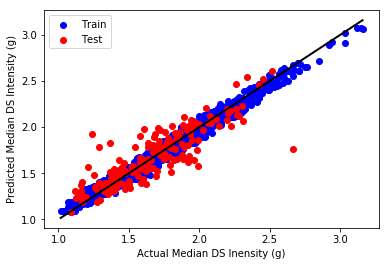

In [12]:
# reXGB_Slight = param_randomizedtune_pipline(XGBRegressor(), Retrofit_TrainTest_DesignMatrix, Retrofit_Verification_DesignMatrix, np.divide(DamageState_Retrofit['Slight'], np.repeat(DamageState_Existing['Slight'],5)), 
# np.divide(DamageState_Verification.loc[32:,'Slight'], pd.concat([DamageState_Verification.loc[0:31,'Slight']]*4)), param_grid, plot_flag = True)

DF1 = pd.DataFrame(data = np.divide(DamageState_Retrofit['Slight'], np.repeat(DamageState_Existing['Slight'],5)))
DF2 = pd.DataFrame(data = np.divide(DamageState_Verification.loc[32:,'Slight'], pd.concat([DamageState_Verification.loc[0:31,'Slight']]*4)))
assemble_response = DF1.append(DF2)

X_train, X_test, y_train, y_test = train_test_split(Retrofit_TrainTest_DesignMatrix.append(Retrofit_Verification_DesignMatrix), assemble_response ,test_size = 0.1)

reXGB_Slight = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train, y_test, param_grid, plot_flag = True)

[20:34:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 2.40
Testing Median Absolute Error Ratio 6.09


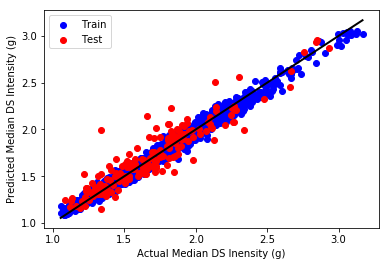

In [13]:
# reXGB_Moderate = param_randomizedtune_pipline(XGBRegressor(), Retrofit_TrainTest_DesignMatrix, Retrofit_Verification_DesignMatrix, np.divide(DamageState_Retrofit['Moderate'], np.repeat(DamageState_Existing['Moderate'],5)), 
# np.divide(DamageState_Verification.loc[32:,'Moderate'], pd.concat([DamageState_Verification.loc[0:31,'Moderate']]*4)), param_grid, plot_flag = True)

DF1 = pd.DataFrame(data = np.divide(DamageState_Retrofit['Moderate'], np.repeat(DamageState_Existing['Moderate'],5)))
DF2 = pd.DataFrame(data = np.divide(DamageState_Verification.loc[32:,'Moderate'], pd.concat([DamageState_Verification.loc[0:31,'Moderate']]*4)))
assemble_response = DF1.append(DF2)

X_train, X_test, y_train, y_test = train_test_split(Retrofit_TrainTest_DesignMatrix.append(Retrofit_Verification_DesignMatrix), assemble_response ,test_size = 0.1)

reXGB_Moderate = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train, y_test, param_grid, plot_flag = True)

[20:34:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 2.27
Testing Median Absolute Error Ratio 7.27


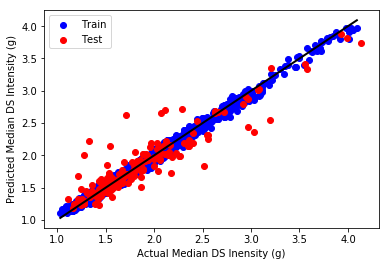

In [14]:
# reXGB_Severe = param_randomizedtune_pipline(XGBRegressor(), Retrofit_TrainTest_DesignMatrix, Retrofit_Verification_DesignMatrix, np.divide(DamageState_Retrofit['Severe'], np.repeat(DamageState_Existing['Severe'],5)), 
# np.divide(DamageState_Verification.loc[32:,'Severe'], pd.concat([DamageState_Verification.loc[0:31,'Severe']]*4)), param_grid, plot_flag = True)

DF1 = pd.DataFrame(data = np.divide(DamageState_Retrofit['Severe'], np.repeat(DamageState_Existing['Severe'],5)))
DF2 = pd.DataFrame(data = np.divide(DamageState_Verification.loc[32:,'Severe'], pd.concat([DamageState_Verification.loc[0:31,'Severe']]*4)))
assemble_response = DF1.append(DF2)

X_train, X_test, y_train, y_test = train_test_split(Retrofit_TrainTest_DesignMatrix.append(Retrofit_Verification_DesignMatrix), assemble_response ,test_size = 0.1)

reXGB_Severe = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train, y_test, param_grid, plot_flag = True)

[20:34:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 2.03
Testing Median Absolute Error Ratio 7.31


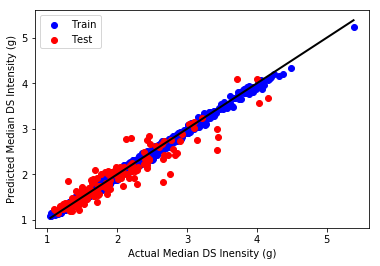

In [15]:
# reXGB_Complete = param_randomizedtune_pipline(XGBRegressor(), Retrofit_TrainTest_DesignMatrix, Retrofit_Verification_DesignMatrix, np.divide(DamageState_Retrofit['Complete'], np.repeat(DamageState_Existing['Complete'],5)), 
# np.divide(DamageState_Verification.loc[32:,'Complete'], pd.concat([DamageState_Verification.loc[0:31,'Complete']]*4)), param_grid, plot_flag = True)

DF1 = pd.DataFrame(data = np.divide(DamageState_Retrofit['Complete'], np.repeat(DamageState_Existing['Complete'],5)))
DF2 = pd.DataFrame(data = np.divide(DamageState_Verification.loc[32:,'Complete'], pd.concat([DamageState_Verification.loc[0:31,'Complete']]*4)))
assemble_response = DF1.append(DF2)

X_train, X_test, y_train, y_test = train_test_split(Retrofit_TrainTest_DesignMatrix.append(Retrofit_Verification_DesignMatrix), assemble_response ,test_size = 0.1)

reXGB_Complete = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train, y_test, param_grid, plot_flag = True)

In [16]:
import pickle
os.chdir(r'C:\Users\User\Desktop\XGBoostPipline\Models\MixedTrainTest\Existing')

with open('Slight.pkl', 'wb') as file:
    pickle.dump(XGB_Slight, file)
with open('Moderate.pkl', 'wb') as file:
    pickle.dump(XGB_Moderate, file)
with open('Severe.pkl', 'wb') as file:
    pickle.dump(XGB_Severe, file)
with open('Complete.pkl', 'wb') as file:
    pickle.dump(XGB_Complete, file)




In [17]:
os.chdir(r'C:\Users\User\Desktop\XGBoostPipline\Models\MixedTrainTest\Retrofit')
with open('Retrof_Slight_Ratio.pkl', 'wb') as file:
    pickle.dump(reXGB_Slight, file)
with open('Retrof_Moderate_Ratio.pkl', 'wb') as file:
    pickle.dump(reXGB_Moderate, file)
with open('Retrof_Severe_Ratio.pkl', 'wb') as file:
    pickle.dump(reXGB_Severe, file)
with open('Retrof_Complete_Ratio.pkl', 'wb') as file:
    pickle.dump(reXGB_Complete, file)